# Protein Ligand Interaction Diagram Generator

## Essiencially, this is a free protein preparation process, and at last you will get the prepared structure named as 
```complex_prepared.pdb``` 
## while the 2D interaction is just inside this notebook which is online, you can just copy and paste it to anywhere you want.

- This workflow allow you to input a PDB bank protein-ligand co-crystal structure.
- The structure will be splited and prepared separately
- The prepared structures then combined again
- The 2D interaction is draw based on the merged structure
- The user is expected to provide the PDB ID and the ligand name as per in the PDB database which can be found on small molecule section of the PDB main page of the corresponding structure

In [33]:
#@title Input expected from the user
PDB_ID = "6NZP" #@param {type:"string"}
pdb = PDB_ID + ".pdb"
! wget https://files.rcsb.org/download/$pdb
#@title Ligand three-letter name
Ligand = "LB7" #@param {type:"string"}


--2023-02-01 09:20:32--  https://files.rcsb.org/download/6NZP.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.134
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘6NZP.pdb.1’

6NZP.pdb.1              [   <=>              ] 390.52K   752KB/s    in 0.5s    

2023-02-01 09:20:33 (752 KB/s) - ‘6NZP.pdb.1’ saved [399897]



# Install Conda

In [28]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


# Install dependencies

In [29]:
!conda install -c conda-forge openmm -y
!conda install -c conda-forge pdbfixer -y
!yes|conda install -c conda-forge pymol-open-source 2>&1 1>/dev/null
!conda install -c rdkit rdkit -y 2>&1 1>/dev/null
!conda install -q -y -c openbabel openbabel 2>&1 1>/dev/null
!conda install -c conda-forge mdanalysis 2>&1 1>/dev/null
!conda install -c conda-forge prolif 2>&1 1>/dev/null

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.



In [83]:
import sys
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
print(rdBase.rdkitVersion)
from openbabel import pybel
import MDAnalysis as mda
import prolif as plf

2022.09.4


# Write out a Pytmol script that can split protein and ligand
Only Chain A retained

In [61]:
#@title Write out a script for pymol
com_file = open('split.pml','w')
com_file.write('''
load 3HTB.pdb
remove not chain A
remove resn HOH
h_add elem O or elem N
select 3HTB-JZ4, resn JZ4 #Create a selection called 1OYT-FSN from the ligand
select 3HTB-receptor, 3HTB and not 3HTB-JZ4 #Select all that is not the ligand
save 3HTB-JZ4.pdb, 3HTB-JZ4
save 3HTB-receptor.pdb, 3HTB-receptor    
''')
com_file.close()

In [62]:
#@title Correct the script with right PDB ID and ligand name
!sed -i 's/3HTB/{PDB_ID}/g' split.pml
!sed 's/JZ4/{Ligand}/g' split.pml
!sed -i 's/JZ4/{Ligand}/g' split.pml


load 6NZP.pdb
remove not chain A
remove resn HOH
h_add elem O or elem N
select 6NZP-LB7, resn LB7 #Create a selection called 1OYT-FSN from the ligand
select 6NZP-receptor, 6NZP and not 6NZP-LB7 #Select all that is not the ligand
save 6NZP-LB7.pdb, 6NZP-LB7
save 6NZP-receptor.pdb, 6NZP-receptor    


In [63]:
#@title Run pymol to split protein and native ligand
!pymol -c split.pml

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 2 CPU cores.  Enabled multithreaded rendering.
PyMOL>load 6NZP.pdb
HEADER    TRANSFERASE                             14-FEB-19   6NZP
TITLE     CRYSTAL STRUCTURE OF TYROSINE KINASE 2 JH2 (PSEUDO KINASE DOMAIN)
TITLE    2 COMPLEXED WITH COMPOUND-1

# Splited protein and ligand is allocated to 2 variables, respectively

In [78]:
Protein_PDB_file_name = PDB_ID + '-receptor.pdb'
ligand_name = PDB_ID + '-' + Ligand + '.pdb'

# ligand name is to changed to LIG as a general variable

In [98]:
!sed -i 's/{Ligand}/LIG/g' {ligand_name}

# Prepare the protein only

In [82]:
from pdbfixer import PDBFixer
from openmm.app import PDBFile
fixer = PDBFixer(filename=Protein_PDB_file_name)
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(7.0)
fixer.addSolvent(fixer.topology.getUnitCellDimensions())
PDBFile.writeFile(fixer.topology, fixer.positions, open('output.pdb', 'w'))

# Prepare the ligand
This give the ligand correct H atoms since they do not exist in PDB bank, also give ligand correct charges

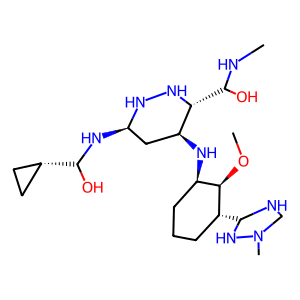

In [114]:
m=Chem.MolFromPDBFile(ligand_name)
Draw.MolToImage(m)

In [115]:
!obabel -ipdb {ligand_name} -omol2 -O ligand.mol2 -h

1 molecule converted


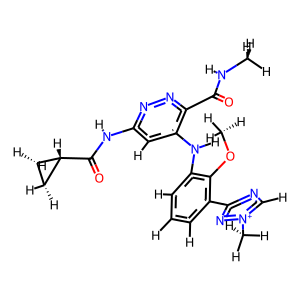

In [116]:
m=Chem.MolFromMol2File('ligand.mol2',sanitize=False)
Draw.MolToImage(m)

In [102]:
#mol= [m for m in pybel.readfile(filename='ligand.mol2',format='mol2')][0]
#mol.addh()
#out=pybel.Outputfile(filename='ligand2.mol2',format='mol2',overwrite=True)
#out.write(mol)
#out.close()

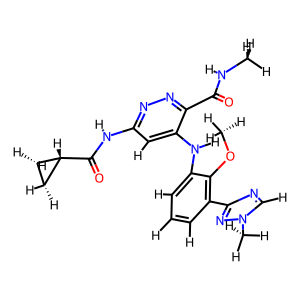

In [103]:
#m=Chem.MolFromMol2File('ligand2.mol2',sanitize=False)
#Draw.MolToImage(m)

In [117]:
!obabel -imol2 ligand.mol2 -opdb -O ligand2.pdb -h

1 molecule converted


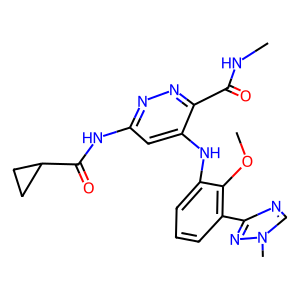

In [119]:
m=Chem.MolFromPDBFile('ligand2.pdb')
Draw.MolToImage(m)

In [ ]:
# Save the ligand and prepared protein together

# Merge the prepared protein and ligand again

In [125]:
#@title Write out a script for pymol
com_file = open('merge.pml','w')
com_file.write('''
load output.pdb
load ligand2.pdb
h_add elem O or elem N
save complex_prepared.pdb, all   
''')
com_file.close()

In [126]:
!pymol -c merge.pml

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Detected 2 CPU cores.  Enabled multithreaded rendering.
PyMOL>load output.pdb
 ObjectMolecule: Read crystal symmetry information.
 CmdLoad: "" loaded as "output".
PyMOL>load ligand2.pdb
COMPND    6NZP-LB7.pdb
 CmdLoad: "" loaded as "ligand2".
PyMOL>h_add 

# Read the merged complex into MDAnalysis as an python object
Allocate two Rdkit variables to ligand and protein, respectively

In [128]:
import numpy as np
# load topology
u = mda.Universe('complex_prepared.pdb')
lig = u.select_atoms("resname LIG")
prot = u.select_atoms("protein")

# Show a 2D ligand
This is done with Rdkit

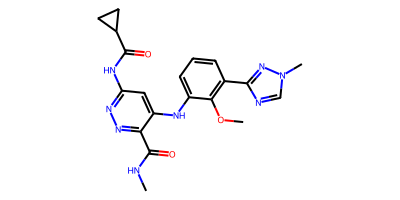

In [129]:
from rdkit import Chem
from rdkit.Chem import Draw

# create a molecule from the MDAnalysis selection
lmol = plf.Molecule.from_mda(lig)
# cleanup before drawing
mol = Chem.RemoveHs(lmol)
mol.RemoveAllConformers()
Draw.MolToImage(mol, size=(400, 200))

# Show the 2D interaction between protein and ligand
This is done by ProLif

In [130]:
from prolif.plotting.network import LigNetwork

fp = plf.Fingerprint()
fp.run(u.trajectory[::10], lig, prot)
df = fp.to_dataframe(return_atoms=True)

net = LigNetwork.from_ifp(
    df,
    lmol,
    # replace with `kind="frame", frame=0` for the other depiction
    kind="aggregate",
    threshold=0.3,
    rotation=270,
)
net.display()

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.8/multiprocessing/reduction.py:51: UserWarning: Reader has no dt information, set to 1.0 ps
  cls(buf, protocol).dump(obj)
/usr/local/lib/python3.8/site-packages/prolif/plotting/network.py:292: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.get_dummies(
/usr/local/lib/python3.8/site-packages/prolif/plotting/network.py:292: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.get_dummies(
